In [1]:
from sklearn.linear_model import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import impyute as impy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data_file = pd.read_csv("../TAMU_FINAL_DATASET_2018.csv")

In [3]:
# Process categroical variable
def catogrical_var_onehot(data_file):
    categorical_data = data_file.select_dtypes(exclude=['float64','int64'])
    categorical_df = pd.DataFrame()
    for column in categorical_data.columns:
        dummies = pd.get_dummies(categorical_data[column], prefix=column)
        categorical_df = pd.concat([categorical_df, dummies], axis=1)
    return categorical_df

# Process numerical variable
def numeric_var(data_file):
    numeric_df = data_file.select_dtypes(include=['float64','int64'])
    return numeric_df

# Compute na values
def fill_na(df):
    df_column = df.columns
    df_nona = impy.mice(df.values)
    df_nona = pd.DataFrame(df_nona, columns=df_column)
    return df_nona

whole_df = pd.concat([numeric_var(data_file), catogrical_var_onehot(data_file)], axis=1)
whole_df = fill_na(whole_df)

In [4]:
# ~2700 AMIFLAG = 1 entries and same amount of flag = 0
def balanced_data(df):
    df_AMI = df[df['AMI_FLAG'] == 1]
    df_NOAMI = df[df['AMI_FLAG'] == 0]
    df_NOAMI_sample = df_NOAMI.sample(df_AMI.shape[0])
    balanced_df = pd.concat([df_AMI, df_NOAMI_sample], axis = 0)
    return balanced_df

balanced_df = balanced_data(whole_df)

In [5]:
def train_test_set(df):
    X = df.loc[:, df.columns != 'AMI_FLAG']
    y = df['AMI_FLAG']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
    return_dic = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train, 'y_test':y_test}
    return return_dic

whole_suite = train_test_set(whole_df)
balanced_suite = train_test_set(balanced_df)

In [6]:
def logistic_model(suite):
    # construct linear model using sklearn 
    lm = LogisticRegression(penalty='l1')
    model = lm.fit(suite['X_train'], suite['y_train'])
    return model

def random_forest_model(suite):
    clf = RandomForestClassifier(n_estimators=300,
                                min_samples_leaf=2,
                                min_samples_split=10,
                                max_depth=10,
                                max_features='log2',
                                criterion='entropy',)
    model = clf.fit(suite['X_train'], suite['y_train'])
    return model

def decision_tree_model(suite):
    clf = DecisionTreeClassifier(min_samples_leaf=1, max_features='sqrt', 
                             max_depth=10, criterion='gini')
    model = clf.fit(suite['X_train'], suite['y_train'])
    return model

def test_on(X, model, y):
    pred = model.predict(X)
    accuracy = accuracy_score(y, pred)
    #print("Accuracy is: " + str(accuracy))
    return accuracy


In [7]:
log_model_balanced = logistic_model(balanced_suite)
rf_model_balanced = random_forest_model(balanced_suite)
dt_model_balanced = decision_tree_model(balanced_suite)

log_model_whole = logistic_model(whole_suite)
rf_model_whole = random_forest_model(whole_suite)
dt_model_whole = decision_tree_model(whole_suite)

In [30]:
def model_result(input_model, train_suite, rep):
    accuracy_dic = {}
    accuracy_dic['balanced_train'] = []
    accuracy_dic['balanced_test'] = []
    accuracy_dic['whole_train'] = []
    accuracy_dic['whole_test'] = []
    for i in range(rep):
        trained_model = input_model(train_suite)
        accuracy_dic['balanced_train'].append(test_on(balanced_suite['X_train'], trained_model, balanced_suite['y_train']))
        accuracy_dic['balanced_test'].append(test_on(balanced_suite['X_test'], trained_model, balanced_suite['y_test']))
        accuracy_dic['whole_train'].append(test_on(whole_suite['X_train'], trained_model, whole_suite['y_train']))
        accuracy_dic['whole_test'].append(test_on(whole_suite['X_test'], trained_model, whole_suite['y_test']))
    return accuracy_dic

def plot_model(input_list):
    ax = plt.subplot()
    ax.plot(input_list['balanced_train'], label = 'Balanced Train')
    ax.plot(input_list['balanced_test'], label = 'Balanced Test')
    ax.plot(input_list['whole_train'], label = 'Original Train')
    ax.plot(input_list['whole_test'], label = 'Original Test')
    ax.legend(loc="upper right")
    return ax

In [10]:
# Logistic model trained on balanced dataset:
balanced_log_list = model_result(logistic_model, balanced_suite, 10)

Text(0.5,1,'Logistic Regression Trained on Balanced Data')

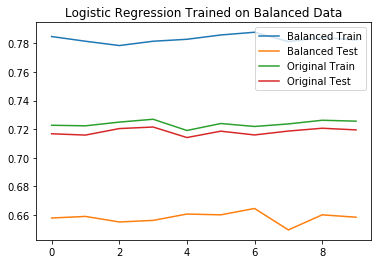

In [31]:
plot_model(balanced_log_list).set_title("Logistic Regression Trained on Balanced Data")

In [12]:
# Logistic model trained on original dataset:
whole_log_list = model_result(logistic_model, whole_suite, 10)

Text(0.5,1,'Logistic Regression Trained on Original Data')

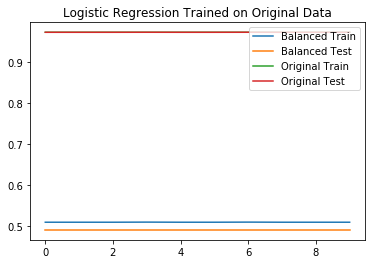

In [32]:
plot_model(whole_log_list).set_title("Logistic Regression Trained on Original Data")

In [14]:
# Decision tree model on balanced dataset:
balanced_dt_list = model_result(decision_tree_model, balanced_suite, 10)

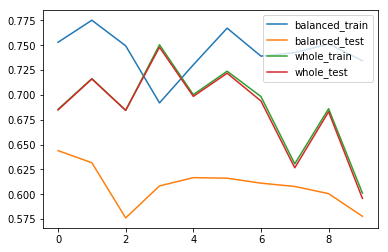

In [15]:
plot_model(balanced_dt_list).set_title("Decision Tree Trained on Balanced Data")

In [16]:
# Decision tree model on whole dataset:
whole_dt_list = model_result(decision_tree_model, whole_suite, 10)

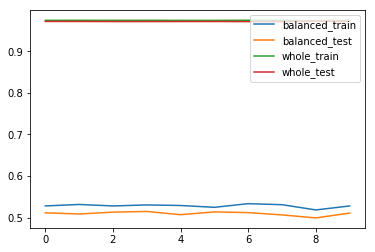

In [17]:
plot_model(whole_dt_list).set_title("Decision Tree Trained on Original Data")

In [18]:
# Random Forest model trained on balanced dataset:
balanced_log_list = model_result(random_forest_model, balanced_suite, 10)

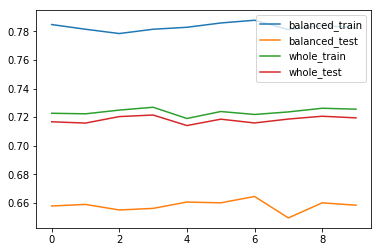

In [19]:
plot_model(balanced_log_list).set_title("Random Forest Trained on Balanced Data")

In [20]:
# Random Forest model on whole dataset:
whole_dt_list = model_result(random_forest_model, whole_suite, 10)

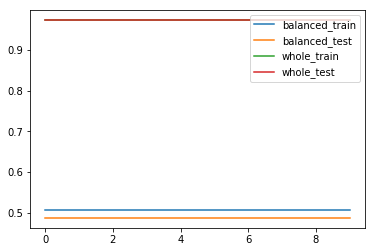

In [21]:
plot_model(whole_dt_list).set_title("Random Forest Trained on Original Data")